In [1]:
import torch
from torch.nn import functional as F
from torch import nn
from torch.utils.data import DataLoader, Dataset
from xgboost import XGBClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import pyreadr
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from tqdm import tqdm
import random

import warnings

warnings.filterwarnings('ignore', category=UserWarning)

torch.manual_seed(42)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Anomaly Detection on Tennessee Eastman Process Data
The *Tennessee Eastman Process Data* data set is a simulation data set consisting of multivariate time series (containing 52 time series features). The time series are available both in the normal state and with anomalies. Each point in time is therefore provided with a label that indicates the state in which the data point is in. The label 0 indicates that the time series is in a normal state, while the labels 1-20 stand for different anomaly cases.

The data set simulates the behavior of a modern  Industrial Control Systems (ICS), which in the real world is often described by several time series recorded by many sensors. Anomalies can occur in these systems, which must be detected. The  *Tennessee Eastman Process Data* is therefore an optimal data set for testing algorithms for automated anomaly detection in such systems

This project deals with different algorithms for automated anomaly detection. An unsupervised algorithm (Variantional Autoencoder), as well as supervised learning algorithms such as binary- and mutli-label classification gradient boosting and long short-term memory (LSTM) networks.

# Loading the dataset and exploration

The data set consists of 4 RData files that split the data set into training data and test data. The data is loaded and merged into a single dataframe.

In [3]:
# initial pandas dataframe
df = pd.DataFrame()

# loop to load all 4 files and concat them into a single dataframe
for path in glob.glob("data/*.RData"):
    _df = pyreadr.read_r(path)
    # the data is loaded in form a dictionary with one key-value pair
    k = list(_df.keys())[0]
    _df =  _df[k]
    df = pd.concat([df, _df]).astype(np.float32)

df = df.reset_index()
df.head(5)

,index,faultNumber,simulationRun,sample,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
0,0,0.0,1.0,1.0,0.25171,3672.399902,4466.299805,9.5122,27.056999,42.473000,...,54.493999,24.527000,59.709999,22.357000,40.148998,40.074001,47.955002,47.299999,42.099998,15.345000
1,1,0.0,1.0,2.0,0.25234,3642.199951,4568.700195,9.4145,26.999001,42.585999,...,53.269001,24.465000,60.466000,22.413000,39.956001,36.651001,45.037998,47.501999,40.553001,16.063000
2,2,0.0,1.0,3.0,0.24840,3643.100098,4507.500000,9.2901,26.927000,42.278000,...,54.000000,24.860001,60.641998,22.198999,40.074001,41.868000,44.553001,47.479000,41.341000,20.452000
3,3,0.0,1.0,4.0,0.25153,3628.300049,4519.299805,9.3347,26.999001,42.330002,...,53.860001,24.552999,61.908001,21.981001,40.140999,40.066002,48.048000,47.439999,40.779999,17.122999
4,4,0.0,1.0,5.0,0.21763,3655.800049,4571.000000,9.3087,26.900999,42.402000,...,53.306999,21.775000,61.890999,22.412001,37.695999,38.294998,44.678001,47.529999,41.089001,18.681000


It is important to get a rough overview of the characteristics of the data set at the beginning. As we will see, the different characteristics of the data set lie in different numerical ranges. Large differences in the numerical ranges of the features often lead to problems in machine learning algorithms, as features with higher values are given more attention during learning. This needs to be corrected later with the help of a scaler.

In [4]:
# print important key figures of the data set
df.describe()

,index,faultNumber,simulationRun,sample,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
count,1.533000e+07,1.533000e+07,1.533000e+07,1.533000e+07,1.533000e+07,1.533000e+07,1.533000e+07,1.533000e+07,1.533000e+07,1.533000e+07,...,1.533000e+07,1.533000e+07,1.533000e+07,1.533000e+07,1.533000e+07,1.533000e+07,1.533000e+07,1.533000e+07,1.533000e+07,1.533000e+07
mean,3.830818e+06,1.000003e+01,2.505003e+02,4.017329e+02,2.578313e-01,3.664629e+03,4.508767e+03,9.381279e+00,2.690145e+01,4.237013e+01,...,5.456402e+01,2.948042e+01,6.346111e+01,2.312506e+01,3.950932e+01,3.805743e+01,4.643279e+01,4.987652e+01,4.196305e+01,1.915971e+01
std,2.698727e+06,6.055301e+00,1.443373e+02,2.637147e+02,1.409454e-01,4.290828e+01,1.070059e+02,3.671576e-01,2.282361e-01,3.164791e-01,...,6.753467e+00,1.939544e+01,8.219346e+00,1.192272e+01,1.279515e+01,2.942525e+00,2.347796e+00,1.714415e+01,1.100319e+01,7.642519e+00
min,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,-4.985500e-03,3.308400e+03,3.540700e+03,6.639900e+00,2.534800e+01,3.965600e+01,...,7.348400e+00,-3.586600e-01,-5.222600e-03,-1.068800e-01,0.000000e+00,2.228800e+01,3.336900e+01,-6.834200e-01,-5.156500e-01,-6.774200e-03
25%,1.551250e+06,5.000000e+00,1.257500e+02,1.830000e+02,2.196600e-01,3.637400e+03,4.472300e+03,9.271300e+00,2.676200e+01,4.218700e+01,...,5.353800e+01,2.225300e+01,6.035000e+01,2.152700e+01,3.839200e+01,3.601800e+01,4.486600e+01,4.547400e+01,4.061300e+01,1.712400e+01
50%,3.467500e+06,1.000000e+01,2.505000e+02,3.655000e+02,2.506600e-01,3.663800e+03,4.509100e+03,9.355400e+00,2.690000e+01,4.234900e+01,...,5.397800e+01,2.507500e+01,6.148500e+01,2.214100e+01,3.994800e+01,3.812400e+01,4.633500e+01,4.804000e+01,4.118900e+01,1.826400e+01
75%,5.767499e+06,1.500000e+01,3.752500e+02,5.952500e+02,2.804700e-01,3.690400e+03,4.546600e+03,9.448800e+00,2.704100e+01,4.252300e+01,...,5.442700e+01,2.828900e+01,6.275900e+01,2.269300e+01,4.139000e+01,3.997900e+01,4.802300e+01,5.141500e+01,4.184800e+01,1.948300e+01
max,9.599999e+06,2.000000e+01,5.000000e+02,9.600000e+02,1.017500e+00,3.906700e+03,5.175800e+03,1.224000e+01,2.856500e+01,4.465300e+01,...,1.000000e+02,1.002100e+02,1.000200e+02,1.001100e+02,9.752800e+01,5.423000e+01,6.021600e+01,1.005800e+02,1.006100e+02,1.000100e+02


In [5]:
# print the different labels
df["faultNumber"].unique()

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20.], dtype=float32)

In [6]:
# convert labels to int
df["faultNumber"] = df["faultNumber"].astype(int)

# remove columns "simulationRun", "sample" and "index"
df = df.drop(["simulationRun", "sample", "index"], axis=1)

**To begin with, we filter out anomalies with labels, as these seem to be difficult to detect.**

*From the above references, its being noted that fault 3,9 and 15 are very difficult to detect and hence we will ignore fault 3, 9 and 15 for our models.*

[Reference](https://medium.com/@mrunal68/tennessee-eastman-process-simulation-data-for-anomaly-detection-evaluation-d719dc133a7f)

- Mihajlo Grbovic et.al “Cold start approach for data — driven fault detection”, IEEE Transactions on Industrial Informatics, November 2013.
- Mohamed Bin Shams et .al “Fault Detection using CUMSUM based techniques with application to the Tennessee Eastman Process”, Proceedings of the 9th International Symposium on Dynamics and control of Process Systems.
- Danfeng Xie et .al “ Deep Learning in Visual Computing and Signal Processing”, Review Article, Applied Computation Intelligence and Soft computing, Volume 2017,Article ID 1320780.

In [7]:
# remove 3, 9 and 15
mask = ~df["faultNumber"].isin([3, 9, 15])

In order to learn well, our data must be distributed approximately equally. We sample the data from our dataset so that we obtain the same amount of data with anomalies and data that is in a normal state.

In [8]:
# balance data set
df = df[df['faultNumber']!=0].sample(n=len(df[df['faultNumber']==0]))._append(df[df['faultNumber']==0], ignore_index=True)

In [9]:
# print number of samples for the different cases
df = df[mask]
df["faultNumber"].value_counts(sort=False).sort_index()

faultNumber
0     620560
1      36424
2      36829
3      36717
4      36496
5      36505
6      36131
7      36622
8      36481
9      36734
10     36401
11     36554
12     36234
13     36372
14     36676
15     36644
16     36393
17     36342
18     36423
19     36476
20     36546
Name: count, dtype: int64

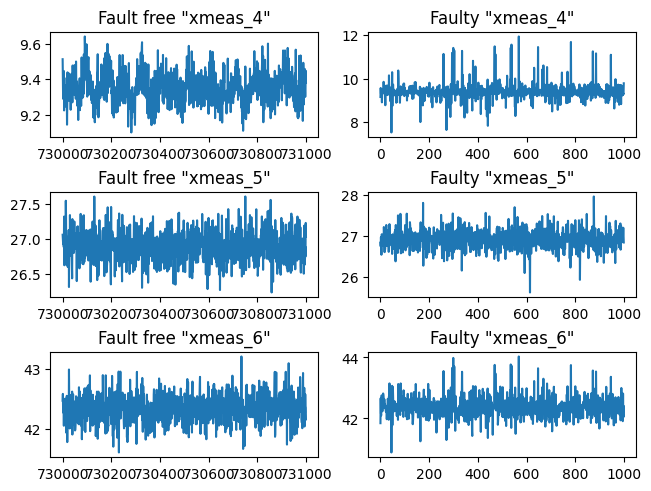

In [10]:
# plotting data to compare faulty and fault free states
keys = df.columns[4:7]
fault_free = df[df["faultNumber"] == 0].iloc[:1_000]
fault = df[df["faultNumber"] > 0].iloc[:1_000]

fig, ax = plt.subplots(3, 2, constrained_layout=True)

for i, key in enumerate(keys):
    ax[i][0].set_title(f'Fault free "{key}"')
    ax[i][0].plot(fault_free[key])
    ax[i][1].set_title(f'Faulty "{key}"')
    ax[i][1].plot(fault[key])
plt.show()

# Statistical analysis (Threshold)

As a baseline, we try to filter out the anomalies using a statistical analysis. The assumption is that the data in the normal state follows a normal distribution and anomalies are outliers that are not within 3 times the standard deviation of the mean value (upper and lower limit).

<img src="images/normal-distribution.png" width="500" height="340">

Reference: [Normal distribution ](https://hammychang.medium.com/normal-distributions-2e395d596c42)

In [11]:
fault_free = df[df["faultNumber"] == 0]

# calculating mean and standard deviation of the time series in normal state
mean = fault_free.mean(axis=0)
std = fault_free.std(axis=0)

# calculating limits in between normal state data should be
upper_limit = mean+3*std
lower_limit = mean-3*std

Now we plot the calculated boundaries as red lines on our data. (Left data in normal state and right anomalies)
Here you can already see that even data in its normal state exceeds the limits. To correct this a bit, we extend the limits to 4x standard deviation.

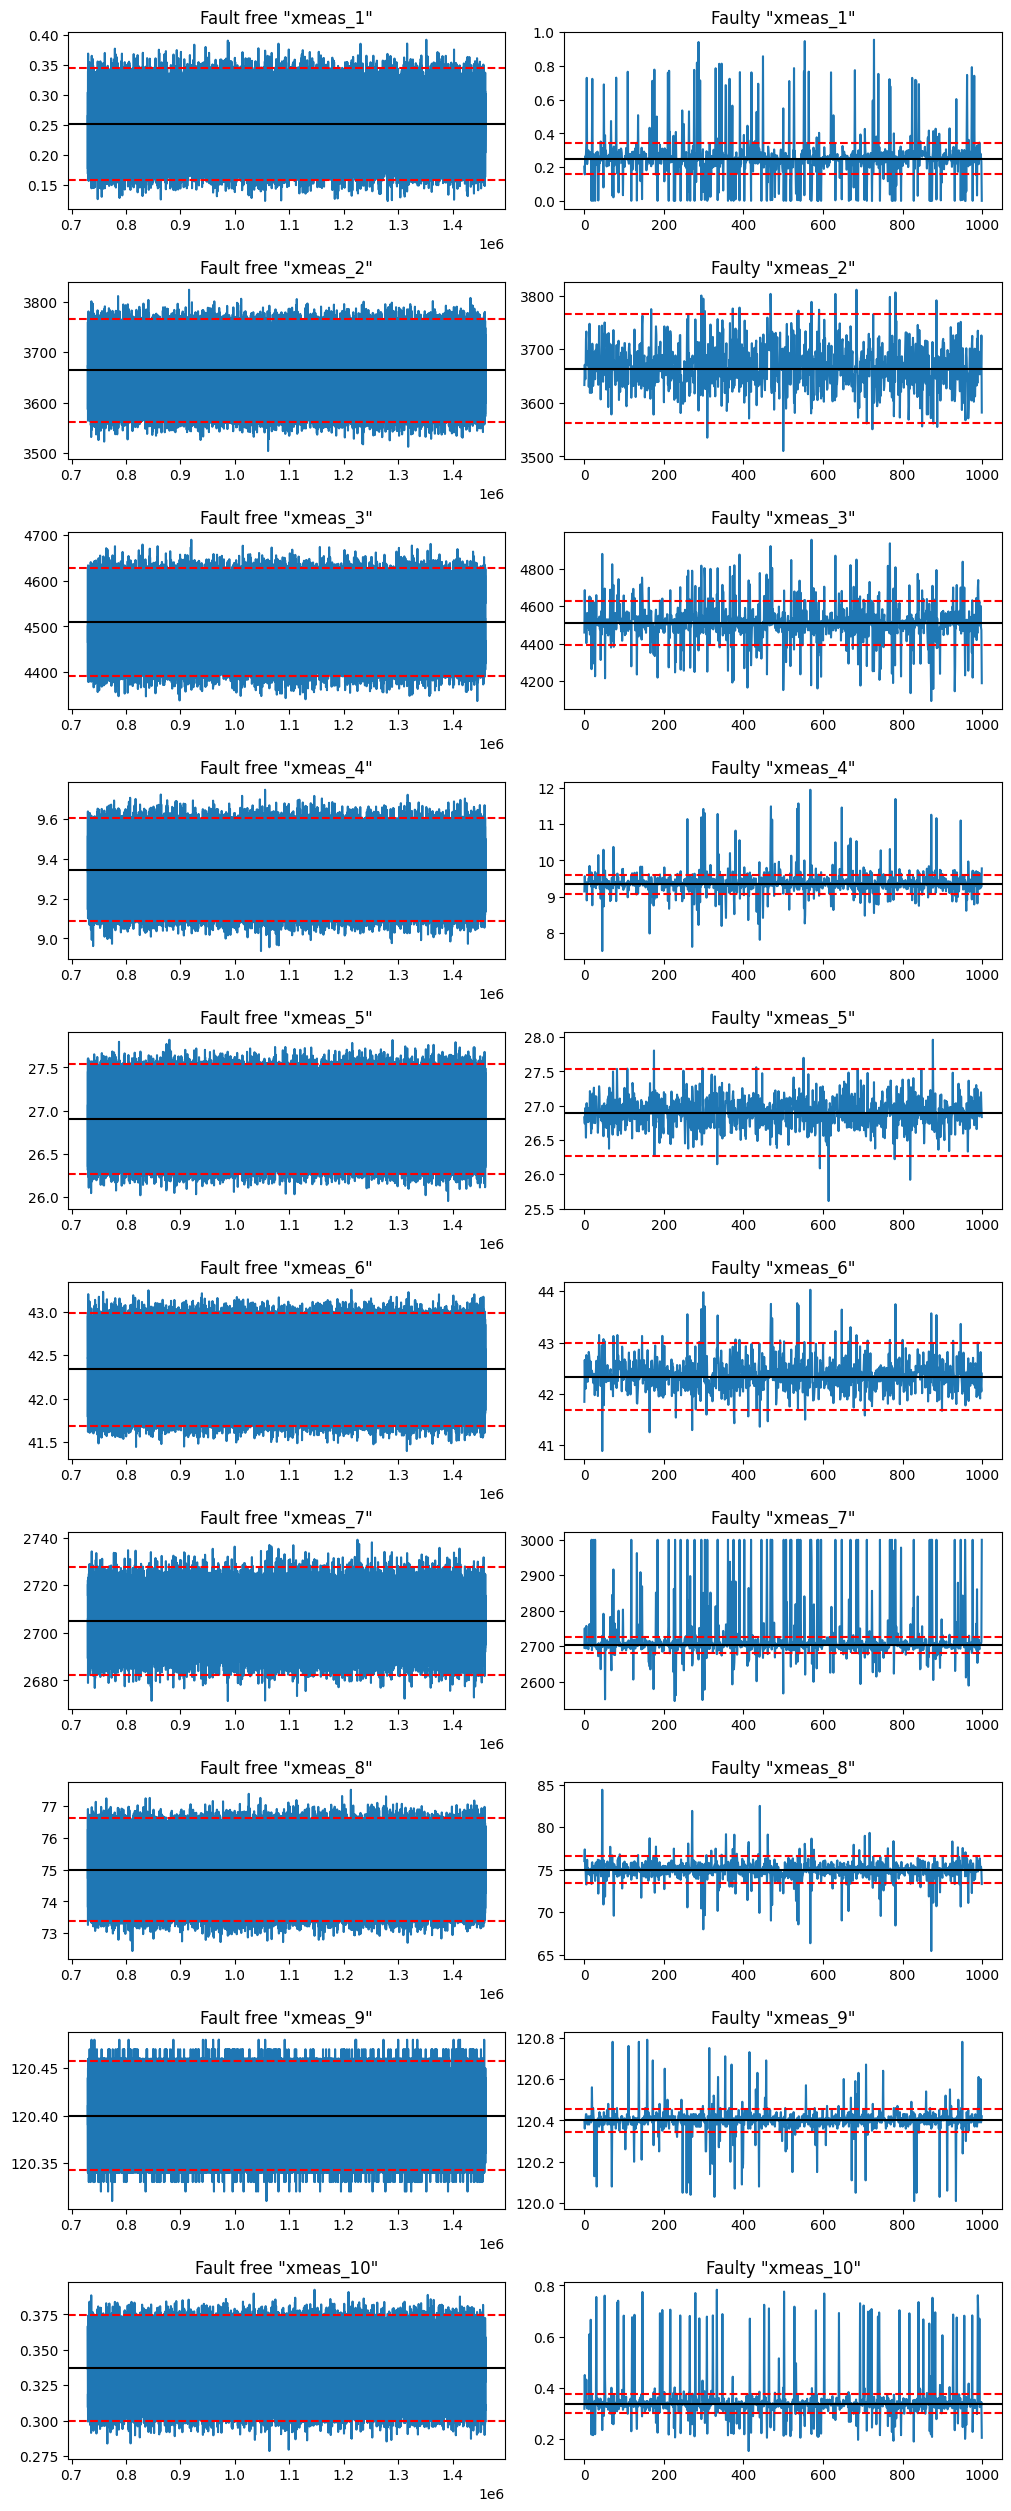

In [12]:
keys = fault.keys()[1:11]

fig, ax = plt.subplots(len(keys), 2, figsize=(10, 25), constrained_layout=True)
simulation_run = 1

for i, key in enumerate(keys):
    ax[i][0].set_title(f'Fault free "{key}"')
    ax[i][0].plot(fault_free[key])
    ax[i][0].axhline(mean[key],c='k')
    ax[i][0].axhline(upper_limit[key],ls='--',c='r')
    ax[i][0].axhline(lower_limit[key],ls='--',c='r')
    
    ax[i][1].set_title(f'Faulty "{key}"')
    ax[i][1].plot(fault[key])
    ax[i][1].axhline(mean[key],c='k')
    ax[i][1].axhline(upper_limit[key],ls='--',c='r')
    ax[i][1].axhline(lower_limit[key],ls='--',c='r')
plt.show()

# Statistical detection

For the detection of anomalies, we apply the calculated limits per feature to the feautes. If one of the 52 features lies outside its limit for a timestamp, the entire data point is recognized as an anomaly.

In [13]:
# mean, stddev, upper limit, lower limit
mean = df[df["faultNumber"] == 0].mean(axis=0)
std = df[df["faultNumber"] == 0].std(axis=0)

# extended limits to 4 times standard deviation
upper_limit = mean+4*std
lower_limit = mean-4*std

In [14]:
# Check if feature sample is in between the limits
def is_anomaly(column, key):
    """Check if datasamples of a feature are in calcualted limits.
    Args:
        column: numpy array of values from a feature of the dataset. (df["feature"].values)
        key: feature name to lookup the calculated limits for a feature

    Returns:
        - 1 if a sample is an anomaly
        - 0 if a sample is in normal state
    """
    # check if feature is in between limits (returns boolean)
    result = ((column < lower_limit[key]).any()) or ((column > upper_limit[key]).any())
    return 1 if result else 0

# vectorize function to call it on complete column
is_anomaly = np.vectorize(is_anomaly)

In [15]:
# store features to check (column with index 0 is label)
features = list(df.columns[1:])

# stores for every feature in each time step the detected state (0 or 1)
# will later be transformed to a pandas dataframe for result evaluation
result_rows = {}

with tqdm(total=len(df.columns[1:])) as pbar:
    # loop to a list of feature names
    for col in df.columns[1:]:
        # calculate result for each sample of a feature (to results are columnwise calculated)
        result = is_anomaly(df[col], col)
        result_rows[col] = result
        pbar.update(1)

100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [04:05<00:00,  4.71s/it]


In [16]:
# convert results to a pandas dataframe
df_results =  pd.DataFrame(result_rows)

# get max value per row. If an anomaly is detected, "y_pred" is 1 else 0
df_results["y_pred"] = pd.DataFrame(result_rows).max(axis=1)

In [17]:
# function to convert data set labels to binary so that these can be compared with the predictions
to_binary = np.vectorize(lambda val: 1 if val > 0 else 0)

# convert data set labels to binary labels
df_results["y_true"] = to_binary(df["faultNumber"].values)

The result for a simple procedure is okay. However, many normal samples were found as anomalies. As already seen in the previous plots, this is probably due to the fact that data in the normal state also crosses the calculated limits.

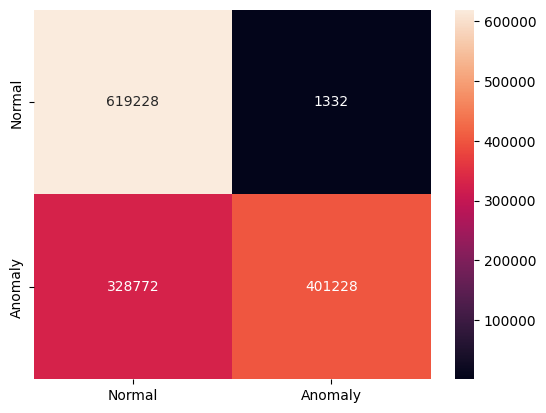

0.7555799075938869

In [18]:
# plotting result confusion matrix and accuracy score
df_results.to_csv("statistical_results.csv")
cm = confusion_matrix(df_results["y_true"].values, df_results["y_pred"].values)
df_cm = pd.DataFrame(cm, index=["Normal", "Anomaly"], columns=["Normal", "Anomaly"])
sns.heatmap(df_cm, annot=True, fmt=".0f")
plt.show()

# store project results
project_results = {}
accuracy = accuracy_score(df_results['y_pred'].values, df_results['y_true'].values)
project_results["statistical analysis"] = accuracy
accuracy

# Unsupervised - Variational Autoencoder

The next algorithm we will look at is a *Variational Autoencoder*, which falls into the class of unsupervised algorithms.

Like normal *Autoencoders*, *Variational Autoencoders* consist of an encoder part that encodes the data into a latent space and a decoder that attempts to reconstruct the input using the encoded data from the latent space.
The latent space is a compression of the input data into a smaller dimensional space. It is desired that the model learns important characteristics of the input and compresses them into the latent space.

In contrast to *Autoencoders*, *Variational Autoencoders* attempt to learn the parameters of a normal distribution for the latent space. We calculate a vector `z_mean` that describes the mean of the latent space and a vector `z_log_var` which forms the logarithm of the variance of the latent space. The logarithm is used for the numerical stability.

*Variational Autoencoders* and *Autoencoders* are often used to generate synthetic data for training models.
They can also be used to detect anomalies, as we will see in the following section.
The idea is to train a Variational Autoencoder on data in a normal state so that the model learns to reconstruct normal data. The quality of the reconstructions is measured using a reconstruction error. If the trained model is then given anomaly data, the model will have difficulty reconstructing it and the reconstruction error will increase. 

## Data scaling
As already seen at the beginning of the data set analysis, the various features are in different value ranges. As machine learning models can have problems when training with features in different value ranges, the features are scaled to similar value ranges so that no one feature stands out.

To scale the values, we use the `StandardScaler` from *Sci-kit learn*, which standardizes the data. During standardization, the mean of the feature is subtracted from each sample so that the mean is 0 afterwards. The data is then divided by the standard deviation so that the resulting feature data is standardized.

In [19]:
# features
X = df.loc[:, df.columns != "faultNumber"].values

# labels
y = df["faultNumber"].values

X.shape, y.shape

((1350560, 52), (1350560,))

In [20]:
# initializing the scaler
scaler = StandardScaler()

# fit the scaler on normal state data
scaler.fit(X[y == 0])

# perform standardized on full data set
scaled_X = scaler.transform(X)
scaled_X.shape

(1350560, 52)

In [21]:
# plot the standardized data
scaled_df = pd.DataFrame(scaled_X, columns=df.columns[df.columns != "faultNumber"])
scaled_df.head(3)

,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,xmeas_8,xmeas_9,xmeas_10,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
0,-1.530177,-0.904187,-1.253314,-2.297350,-0.333177,-2.256982,-1.155002,1.852325,0.000389,-1.558958,...,-0.001779,-1.520985,-0.083030,-1.782842,-1.256090,-0.347867,-0.270920,-0.251191,-1.895715,-0.773994
1,-3.014534,0.208936,4.498337,2.549618,-0.759351,1.484863,6.094522,4.378616,-2.087763,8.965346,...,4.971098,-2.945076,1.679036,4.522302,8.078362,0.391297,-0.008750,-5.306886,0.522445,0.761865
2,0.381171,-0.586156,-0.375297,-0.469848,0.296610,-0.763902,-1.115163,-0.045613,-0.521748,0.702508,...,-0.250743,0.364302,-0.457288,-1.628781,1.144907,0.697344,-0.542028,0.301606,0.100051,1.268583


In [22]:
# plot key characteristics of standardized data
scaled_df.describe()

,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,xmeas_8,xmeas_9,xmeas_10,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
count,1.350560e+06,1.350560e+06,1.350560e+06,1.350560e+06,1.350560e+06,1.350560e+06,1.350560e+06,1.350560e+06,1.350560e+06,1.350560e+06,...,1.350560e+06,1.350560e+06,1.350560e+06,1.350560e+06,1.350560e+06,1.350560e+06,1.350560e+06,1.350560e+06,1.350560e+06,1.350560e+06
mean,1.353161e-01,1.364920e-02,1.081895e-03,2.247703e-01,-3.352668e-03,8.270074e-02,1.379636e+00,-1.324041e-01,7.111573e-03,3.497005e-01,...,7.121908e-01,8.907726e-01,9.837838e-01,9.805265e-01,-1.946515e-01,-7.167700e-03,-2.451328e-02,3.770831e-01,9.040984e-01,3.987393e-01
std,3.470051e+00,1.157146e+00,2.150088e+00,3.289404e+00,1.046837e+00,1.277289e+00,7.737705e+00,1.897731e+00,2.781778e+00,4.907005e+00,...,1.086243e+01,4.863917e+00,5.081192e+00,1.690557e+01,6.339932e+00,9.949871e-01,9.999499e-01,4.685130e+00,1.527647e+01,3.990987e+00
min,-8.194206e+00,-9.759157e+00,-2.180656e+01,-2.937938e+01,-6.512693e+00,-1.217725e+01,-3.732307e+01,-2.387858e+01,-3.915156e+01,-2.536904e+01,...,-9.464212e+01,-8.115642e+00,-4.923392e+01,-4.193374e+01,-2.620685e+01,-4.904861e+00,-4.789937e+00,-1.748604e+01,-7.673788e+01,-1.237917e+01
25%,-8.191645e-01,-7.304474e-01,-7.977656e-01,-7.713270e-01,-6.741180e-01,-6.860501e-01,-7.832238e-01,-8.379574e-01,-5.217485e-01,-8.547888e-01,...,-7.954829e-01,-7.253231e-01,-7.199112e-01,-9.373952e-01,-8.648652e-01,-6.923375e-01,-6.986482e-01,-7.583435e-01,-7.760976e-01,-6.783863e-01
50%,3.657088e-03,-1.395375e-04,3.902589e-03,4.697849e-02,-6.451701e-03,2.843841e-02,2.668741e-02,-4.192964e-02,3.889752e-04,-3.272643e-02,...,4.609681e-03,6.739887e-02,7.357984e-02,-6.564967e-02,-3.334776e-02,5.031211e-03,-4.747969e-02,-1.361074e-02,7.238435e-02,5.232450e-02
75%,8.136269e-01,7.360564e-01,8.132008e-01,9.002075e-01,6.659562e-01,7.658144e-01,8.764701e-01,7.264594e-01,5.225264e-01,7.678279e-01,...,8.132011e-01,9.107476e-01,9.104405e-01,7.666455e-01,7.713463e-01,6.548753e-01,6.551857e-01,8.867531e-01,9.688184e-01,8.083033e-01
max,2.456493e+01,6.684520e+00,1.615942e+01,3.367544e+01,7.873029e+00,9.371615e+00,3.919547e+01,2.117446e+01,2.871158e+01,3.810154e+01,...,9.793849e+01,2.468196e+01,3.109927e+01,1.463504e+02,3.697736e+01,5.213893e+00,4.907350e+00,1.889007e+01,1.097601e+02,5.592303e+01


Since our data consists of time series, we use a *recurrent network* for the *Variational Autoencoder*. *Recurrent networks* require that the input samples are organized into small time series segments per sample. We add a lookback of the last 5 data points to each data point to train the network.

In [23]:
def create_samples(X, y, lookback=5):
    """Transforms samples to data with lookback for reccurent neural networks.

    Args:
        X: Input data to be trained on
        y: Label per sample
        lookback: Timesteps which will be prepended to each sample

    Returns:
       Transformed features with associated labels in a tuple.
    """
    x_out = []
    y_out = []
    with tqdm(total=len(X)-lookback-1) as pbar:
        # toop over data until lookback steps before the end 
        for i in range(len(X)-lookback-1):
            # starting at i and ends i+loogback for each sample
            _x = X[i:i+lookback, :]
            # label which is assigned to the last 5 data points
            _y = y[i+lookback+1]

            # add samples and labels to result data which will be returned
            x_out.append(_x)
            y_out.append(_y)
            pbar.update(1)

    print("Preparing numpy return. This could take some seconds.")
    return np.array(x_out), np.array(y_out)

In [24]:
_x, _y = create_samples(scaled_df.values, y)
_x.shape, _y.shape

100%|███████████████████████████████████████████████████████████████████| 1350554/1350554 [00:00<00:00, 2422126.30it/s]


Preparing numpy return. This could take some seconds.


((1350554, 5, 52), (1350554,))

The data is now split into training data, test data and validation data. The model is trained exclusively on the training data. During training, the performance of the model is measured on data that it did not see during training. The test data is suitable for this, so it can be evaluated whether the model generalizes. It is not sufficient to evaluate the model on the test data alone, as hyperparameters can be selected during training so that the model fits to the test data set without being trained directly on it. A third data set - validation data - is introduced to ensure that the model generalizes after training and performs well on unseen data.

In [25]:
# First splitting data into training and test data
X_train, X_test, y_train, y_test = train_test_split(_x, _y, test_size=0.3, random_state=1)

# split test data into test and validation data
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=1)

In [26]:
# Data split
print("Train:")
print(f"All samples: {X_train.shape[0]}")
print(f"Without anomalies: {X_train[y_train == 0].shape[0]}")
# Test samples
print("Test:")
print(f"All samples: {X_test.shape[0]}")
print(f"Without anomalies: {X_test[y_test == 0].shape[0]}")
# Train samples
print("Validation:")
print(f"All samples: {X_val.shape[0]}")

Train:
All samples: 945387
Without anomalies: 434623
Test:
All samples: 202584
Without anomalies: 93042
Validation:
All samples: 202583


## LSTM VAE

The following section defines the `Encoder` and `Decoder` components of the *Variational Autoencoder*. The respective component is a *recurrent neural network*. The latent space is defined in the `VAE` class and combines `Encoder` and the `Decoder`.

### Encoder
The encoder is the starting point of the *Variational Autoencoder*. It is fed the data and compresses it into a smaller dimensional space, learning a distribution function in the process.

In [27]:
class Encoder(nn.Module):
    """Encoder component of the VAE to encode data into a latent space."""
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.0):
        """Initialize Encoder.

        Args:
            input_size: Number of features
            hidden_size: Dimension of the hidden size of the LSTM
            num_layer: Number of LSTM layers
            dropout: Specifies the percentage of neurons on which dropout should 
                be applied during training to prevent overfitting.
        """
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True,
            bidirectional=False
        )

    def forward(self, X):
        """Encode data to the latent space.

        Args:
            X: Time series input data

        Returns:
            Compressed version of the input data.
        """
        output, (hidden_state, cell_state) = self.lstm(X)
        return hidden_state[-1] # only return last hidden state

### Decoder
The Decoder tries to reconstruct the input data from the encoded represantation of the latent space.

In [28]:
class Decoder(nn.Module):
    """Decoder part of the VAE to reconstruct the input data of the encoder."""
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.0):
        """Initialize Decoder.

        Args:
            hidden_size: Dimension of the hidden size of the LSTM
            num_layer: Number of LSTM layers
            output_size: Number of features to be reconstructed
            dropout: Specifies the percentage of neurons on which dropout should 
                be applied during training to prevent overfitting.
        """
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True,
            bidirectional=False
        )
        # reconstruction layer
        self.linear_recon = nn.Linear(hidden_size, output_size)

    def forward(self, X):
        """Decode input to reconstruct encoder input.

        Args:
            X: Latent sapce representation of the encoder input data

        Returns:
            Reconstruction of the input data of the encoder.
        """
        output, (hidden_state, cell_state) = self.lstm(X) # decode from latent space
        return self.linear_recon(output) # reconstruction output

### VAE
The main component which combines the `Encoder` and `Decoder` and defines the workflow to reconstruct the input data.

In [29]:
class VAE(nn.Module):
    """Variational Autoencoder to reconstruct time series data."""
    def __init__(self, input_size, hidden_size, latent_size, num_layers, device, dropout=0.0):
        """Initialize VAE.

        Args:
            input_size: Number of features
            hidden_size: Dimension of the LSTMs of the encoder and decoder
            latent_size: Dimension of the low dimensional latent space
            num_layer: Number of LSTM layers in the encoder and decoder
            device: Device on which the model will be used (GPU or CPU)
            dropout: Specifies the percentage of neurons on which dropout should 
                be applied during training to prevent overfitting.

        Note:
            The output size will be the same as the input size, because we are trying to reconstruct it.
        """
        super(VAE, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.latent_size = latent_size
        self.device = device

        self.encoder = Encoder(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout
        ).to(self.device)

        self.decoder = Decoder(
            input_size=latent_size, # compressed vector size
            hidden_size=hidden_size,
            output_size=input_size, # reconstruction of features at timestep
            num_layers=num_layers,
            dropout=dropout
        ).to(self.device)

        self.z_mean = nn.Linear((self.hidden_size), self.latent_size).to(self.device)
        self.z_log_var = nn.Linear((self.hidden_size), self.latent_size).to(self.device)

    def reparametrize(self, z_mean, z_log_var):
        eps = torch.randn(z_mean.size(0), z_mean.size(1)).to(self.device)
        z = z_mean + eps * torch.exp(z_log_var/2.)
        return z

    def forward(self, X):
        """Defines the workflow of reconstruction and combindes encoder and decoder.

        Args:
            X: Time series input

        Returns:
            A reconstruction of the input X
        
        """
        # get dimensions of X
        batch_size, seq_len, features_dim = X.shape

        # encode
        # tensor of shape 1*num_layers, batch_size, hidden_size will be returned
        enc_hidden = self.encoder(X)

        # mean vector of the latent space z
        _z_mean = self.z_mean(enc_hidden)
        # logarithmic variance of latent space z
        _z_log_var = self.z_log_var(enc_hidden)
        
        z = self.reparametrize(_z_mean, _z_log_var) # Shape: batch_size, latent_size
        z = z.unsqueeze(1).repeat(1, seq_len, 1)

        decoded = self.decoder(z)

        return decoded, _z_mean, _z_log_var


In [30]:
def vae_loss(pred, label, z_mean, z_log_var):
    """Calcualtes the reconstruction loss and the Kullback-Leibler loss.

    Args:
        pred: Predicted Reconstruction of the VAE
        label: Input data which is should be reconstructed
        z_mean: Mean vecot of the latent space
        z_log_var: logarithmic variance of latent space 

    Returns:
        Tuple of Kullback-Leibler loss and reconstruction loss.
    """
    # reconstruction loss - measures the difference between input data and reconstruction
    reconstruction_loss = F.mse_loss(pred, label)

    # Kullback-Leibler loss to structure the latent space
    kl_div = torch.mean(
            -0.5 * torch.sum(1 + z_log_var - z_mean**2 - torch.exp(z_log_var), dim=1), dim=0
        )
    loss = reconstruction_loss + kl_div #*kld_weight
    return loss, reconstruction_loss

### Dataset

In [31]:
# Pytorch dataset used for training
class TEP(Dataset):
    """Data set template used for training and testing."""
    def __init__(self, x, y):
        """Initialize TEP data set

        Args:
            x: Time series data which will be the model input
            y: Associated labels for x
        """
        super(TEP, self).__init__()
        self.x = x
        self.y = y

    def __len__(self):
        """Magic method for data set length."""
        return len(self.x)

    def __getitem__(self, idx):
        """Magic method to get a tuple of x and y.

        Args:
            idx: Index of tuple which should be returned

        Returns:
            Tuple of x and y at index 'idx'.
        """
        _x = self.x[idx]
        _y = self.y[idx]
        return _x, _y

In [32]:
# defining a trainloader to process training in batches and shuffle the data
train_data = TEP(X_train[y_train == 0], y_train[y_train == 0])
trainloader = DataLoader(train_data, batch_size=256, shuffle=True)

In [33]:
# defining a testloader for evaluate model on test data during training
test_data = TEP(X_test[y_test == 0], y_test[y_test == 0])
testloader = DataLoader(test_data, batch_size=256)

In [34]:
# training epochs
num_epochs = 20

# learning rate
learning_rate = 0.0002

# model
model = VAE(input_size=52, hidden_size=128, latent_size=32, num_layers=12, device=device, dropout=0.2)

# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

# store loss results
result_rows = []

# track losses during the training
train_losses = []
test_losses = []

# start training loop
for i in range(num_epochs):
    # track losses per epoch
    _train_losses = []
    _train_reconstruction_losses = []
    _test_losses = []
    _test_reconstruction_losses = []
    with tqdm(total=len(trainloader)) as pbar:
        # set model in train mode
        model.train()
        for x, _ in trainloader:
            # move input data to model device
            x = x.to(device)
            # predict on input data
            pred, _mean, _logvar = model(x)
            # calculate losses
            loss, reconstruction_loss = vae_loss(pred, x, _mean, _logvar)
            # reset gradients to 0
            optimizer.zero_grad()
            # calculate gradients
            loss.backward()
            # take a optimization step gradient direction
            optimizer.step()
            # detach gradients from losses and get the items to store them
            loss = loss.detach().item()
            _train_losses.append(loss)
            reconstruction_loss = reconstruction_loss.detach().item()
            _train_reconstruction_losses.append(reconstruction_loss)
            
            pbar.update(1)

        # set model into evaluation mode
        model.eval()
        # run evalution on unseen test data
        for x, y in testloader:
            x = x.to(device)
            with torch.no_grad():
                pred, _mean, _logvar = model(x)
            loss, reconstruction_loss = vae_loss(pred, x, _mean, _logvar)
            loss = loss.detach().item()
            _test_losses.append(loss)
            reconstruction_loss = reconstruction_loss.detach().item()
            _test_reconstruction_losses.append(reconstruction_loss)

        # epoch losses
        e_train = np.mean(_train_losses)
        e_test = np.mean(_test_losses)
        train_losses.append(e_train)
        test_losses.append(e_test)
            
        # print epoch results        
        print(f"Epoch {i+1} - train loss: {e_train} - test loss: {e_test}")
        torch.save(model.state_dict(), f"./model/vae/model.pt")

        result_rows.append(
            {
                "train_loss": e_train,
                "train_reconstruction_loss": np.mean(_train_reconstruction_losses),
                "test_loss": e_test,
                "test_reconstruction_loss": np.mean(_test_reconstruction_losses)
            }
        )

100%|██████████████████████████████████████████████████████████████████████████████| 1698/1698 [00:46<00:00, 36.27it/s]


Epoch 1 - train loss: 1.013578290126349 - test loss: 1.001416040645851


100%|██████████████████████████████████████████████████████████████████████████████| 1698/1698 [00:46<00:00, 36.41it/s]


Epoch 2 - train loss: 1.0027712747121167 - test loss: 1.0004827098532036


100%|██████████████████████████████████████████████████████████████████████████████| 1698/1698 [00:46<00:00, 36.23it/s]


Epoch 3 - train loss: 1.0021224551262649 - test loss: 0.9999728826703606


100%|██████████████████████████████████████████████████████████████████████████████| 1698/1698 [00:46<00:00, 36.22it/s]


Epoch 4 - train loss: 1.0016940524988096 - test loss: 0.99960152559228


100%|██████████████████████████████████████████████████████████████████████████████| 1698/1698 [00:46<00:00, 36.36it/s]


Epoch 5 - train loss: 1.0013686277419855 - test loss: 0.999329210473941


100%|██████████████████████████████████████████████████████████████████████████████| 1698/1698 [00:46<00:00, 36.42it/s]


Epoch 6 - train loss: 1.0011342258068643 - test loss: 0.999129321876463


100%|██████████████████████████████████████████████████████████████████████████████| 1698/1698 [00:46<00:00, 36.36it/s]


Epoch 7 - train loss: 1.000958779464762 - test loss: 0.9989826101195681


100%|██████████████████████████████████████████████████████████████████████████████| 1698/1698 [00:47<00:00, 36.03it/s]


Epoch 8 - train loss: 1.0008354667920807 - test loss: 0.9988749634761077


100%|██████████████████████████████████████████████████████████████████████████████| 1698/1698 [00:46<00:00, 36.41it/s]


Epoch 9 - train loss: 1.000747953694055 - test loss: 0.9987959688181406


100%|██████████████████████████████████████████████████████████████████████████████| 1698/1698 [00:46<00:00, 36.33it/s]


Epoch 10 - train loss: 1.0006706505417122 - test loss: 0.9987378485582687


100%|██████████████████████████████████████████████████████████████████████████████| 1698/1698 [00:46<00:00, 36.41it/s]


Epoch 11 - train loss: 1.0006290260346955 - test loss: 0.9986951511639816


100%|██████████████████████████████████████████████████████████████████████████████| 1698/1698 [00:46<00:00, 36.40it/s]


Epoch 12 - train loss: 1.0005860211430786 - test loss: 0.9986637640785385


100%|██████████████████████████████████████████████████████████████████████████████| 1698/1698 [00:47<00:00, 36.08it/s]


Epoch 13 - train loss: 1.0005650339193985 - test loss: 0.9986406664599429


100%|██████████████████████████████████████████████████████████████████████████████| 1698/1698 [00:46<00:00, 36.40it/s]


Epoch 14 - train loss: 1.0005383582783531 - test loss: 0.998623672422472


100%|██████████████████████████████████████████████████████████████████████████████| 1698/1698 [00:46<00:00, 36.36it/s]


Epoch 15 - train loss: 1.0005311141025333 - test loss: 0.9986112875925316


100%|██████████████████████████████████████████████████████████████████████████████| 1698/1698 [00:46<00:00, 36.39it/s]


Epoch 16 - train loss: 1.0005223783011712 - test loss: 0.9986020303689517


100%|██████████████████████████████████████████████████████████████████████████████| 1698/1698 [00:46<00:00, 36.18it/s]


Epoch 17 - train loss: 1.000509559792259 - test loss: 0.9985952164445605


100%|██████████████████████████████████████████████████████████████████████████████| 1698/1698 [00:47<00:00, 36.00it/s]


Epoch 18 - train loss: 1.0005042362339505 - test loss: 0.9985902111281405


100%|██████████████████████████████████████████████████████████████████████████████| 1698/1698 [00:46<00:00, 36.55it/s]


Epoch 19 - train loss: 1.000500487249226 - test loss: 0.9985865081077093


100%|██████████████████████████████████████████████████████████████████████████████| 1698/1698 [00:46<00:00, 36.53it/s]

Epoch 20 - train loss: 1.0004983786910386 - test loss: 0.9985837694052812


In [35]:
# print training results
results = pd.DataFrame(result_rows)
results.to_csv("vae_results.csv")
results

,train_loss,train_reconstruction_loss,test_loss,test_reconstruction_loss
0,1.013578,1.003466,1.001416,1.001172
1,1.002771,1.002653,1.000483,1.000480
2,1.002122,1.002057,0.999973,0.999973
3,1.001694,1.001630,0.999602,0.999601
4,1.001369,1.001305,0.999329,0.999329
5,1.001134,1.001071,0.999129,0.999129
6,1.000959,1.000895,0.998983,0.998982
7,1.000835,1.000772,0.998875,0.998875
8,1.000748,1.000685,0.998796,0.998796
9,1.000671,1.000608,0.998738,0.998738


By plotting the losses we can see if the model is able to learn or overfitts the data. The result shows that the model learns the data and can strongly decrease the loss in the beginning. What is hard to see in the plot but is shown in the result numbers is, that the the train and test losses decrease until the last epoch of training.

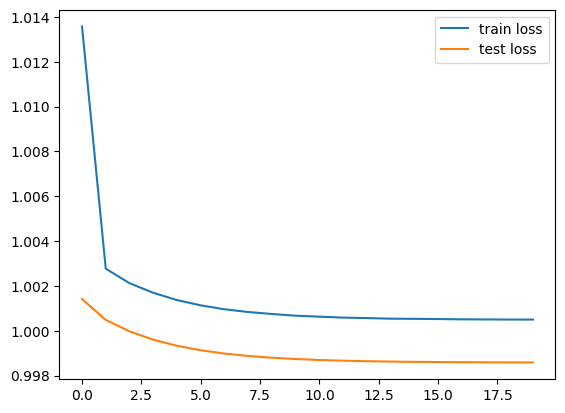

In [36]:
# plot test and training losses
plt.plot(train_losses, label="train loss")
plt.plot(test_losses, label="test loss")
plt.legend()
plt.show()

### Reconstruction plot
To see what the model has learned, we can plot the input data and the reconstruction of the model side by side. The reconstruction is centered around 0, which is the mean of the data on which we have scaled it on.

In [37]:
# sample from input data
sample = X_test[y_test == 0][:100]
with torch.no_grad():
    # reconstruct input data with the trained model
    pred, _, _ = model(torch.from_numpy(sample).to(torch.float32).to(device))
pred = pred.cpu()
pred.shape

torch.Size([100, 5, 52])

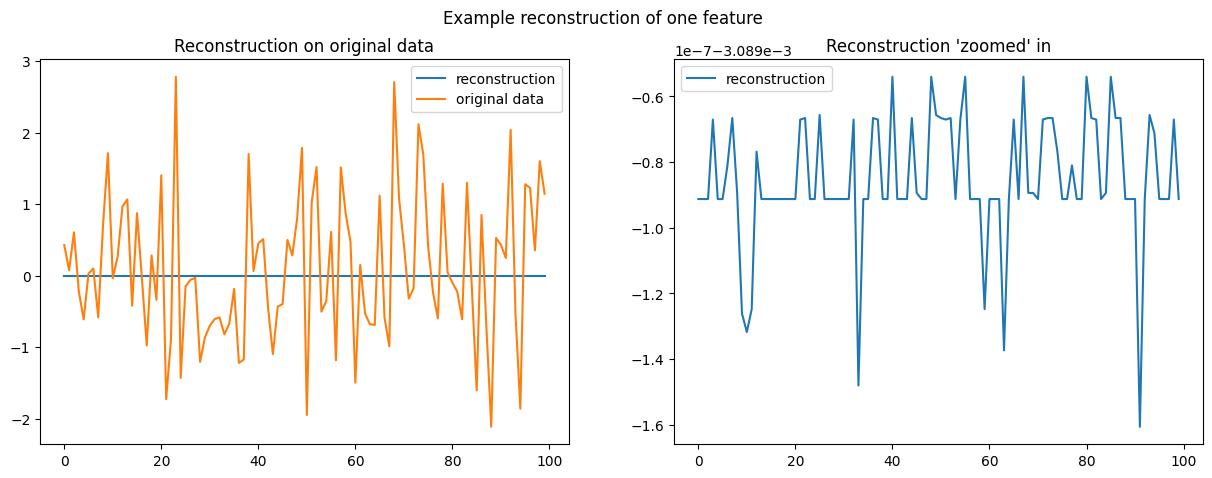

In [38]:
# plot the sample and reconstructed data side by side
fix, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(pred[:, 0, 0], label="reconstruction")
ax[0].plot(sample[:, 0, 0], label="original data")
ax[0].title.set_text("Reconstruction on original data")
ax[0].legend()
ax[1].plot(pred[:, 0, 0], label="reconstruction")
ax[1].title.set_text("Reconstruction 'zoomed' in")
ax[1].legend()
plt.suptitle("Example reconstruction of one feature")
plt.show()

### Evaluation on validation data
After the training we want to evaluate the model on the validation data to see if it can generalize.
Since the model was only trained on data in the normal state, we calculate the maximum reconstruction loss, i.e. the largest error the model made when reconstructing normal data. If the error is higher for newly input data, we assume that this is an anomaly.

In [39]:
y_hat = []
y_true = []

# Get max reconstruction loss of the training data
max_reconstruction_loss = 0
with tqdm(total=len(trainloader)) as pbar:
    for x, _ in trainloader:
        with torch.no_grad():
            x = x.to(device)
            pred, _, _ = model(x)
        r_loss = F.mse_loss(pred, x).cpu().item()

        if r_loss > max_reconstruction_loss:
            max_reconstruction_loss = r_loss
        
        pbar.update(1)

max_reconstruction_loss

100%|██████████████████████████████████████████████████████████████████████████████| 1698/1698 [00:22<00:00, 73.84it/s]


1.0655673742294312

In [40]:
# Evaluating the model with the max reconstructon loss
with tqdm(total=X_val.shape[0]) as pbar:
    for x, y in zip(X_val, y_val):
        with torch.no_grad():
            x = torch.from_numpy(x).to(device)
            x = x[None, :, :]
            pred, _, _ = model(x)
        error = F.mse_loss(pred, x).cpu().item()
        
        y_true.append(1 if y > 0 else 0)
        y_hat.append(1 if error > max_reconstruction_loss else 0)
        
        pbar.update(1)

accuracy = accuracy_score(y_true, y_hat)
project_results["VAE"] = accuracy
accuracy

100%|█████████████████████████████████████████████████████████████████████████| 202583/202583 [05:22<00:00, 627.92it/s]


0.8491877403335917

In [41]:
results = pd.DataFrame({"y_pred": y_hat, "y_true": y_true})
results.to_csv("evaluation_results.csv")

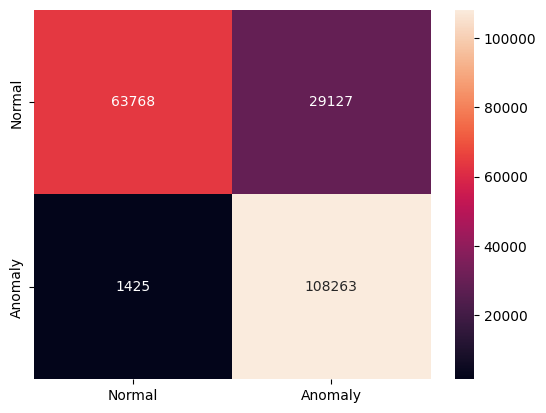

In [42]:
cm = confusion_matrix(y_true, y_hat)
df_cm = pd.DataFrame(cm, index=["Normal", "Anomaly"], columns=["Normal", "Anomaly"])
sns.heatmap(df_cm, annot=True, fmt=".0f")
plt.show()

# Supervised - XGBoost & LSTM
Now we will focus on supervised learning algorithms. Supervised learning assumes that we have a label associated with our input data. We will look at different models in different setups. On the one hand a gradient boost technique with XGBoost on the other hand a recurrent neural network (LSTM). Both models are trained using binary classification and multi-label classification. With binary classification, we only try to detect anomalies. The multi-label classification tries to identify the type of anomaly.

## XGBoost binary classification

To ensure that we work on the same data split as the VAE, we use the before splitted sets in this setup again.

The data was transformed into samples with lookback before splitting. However, the XGBoost algorithm requires the time series to be input as a whole and is not compatible with the current format in which the data is stored. To get the data into a proper format, we extract the first element from each subsequence for each feature (`X[:, 0, :]`), so that we have restored the initial time series for each feature.

For the binary classification, the labels must be transformed into binary labels as in the statistical analysis at the beginning. To do this, we can reuse the `to_binary` function that we defined at the beginning.

In [43]:
# restore X_train
x_train_sequence = X_train[:, 0, :].astype(np.float32)
# transform y_train to binary
y_train_binary = to_binary(y_train)
# restore x_val
x_val_sequence = X_val[:, 0, :].astype(np.float32)
# transform y_val to binary
y_val_binary = to_binary(y_val)

To find the optimal hyperparameters for our model, we search for them using `GridSearchCV` of *Sci-kit learn*. `GridSearchCV` evaluates the model based on all combinations of defined possible hyperparameters and stores the best model.

In [44]:
# define model type
xgb_model = XGBClassifier(device='cuda')
# define possible hyperparameters
optimization_dict = {'max_depth': [2,4,6], 'n_estimators': [50,100,200], "eta": [0.3, 0.03, 0.003]}

# search for the best model based on the possible hyperparamters
model = GridSearchCV(xgb_model, optimization_dict, scoring='accuracy', verbose=1)
model.fit(x_train_sequence, y_train_binary)

# print parameters and score of the best model
print(model.best_score_)
print(model.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
0.8313600662554377
{'eta': 0.3, 'max_depth': 6, 'n_estimators': 200}


In [45]:
# save the best model to disk
best_model = model.best_estimator_
best_model.save_model('./model/xgboost/XGBClassifier_binary.json')

In [46]:
# loading trained model
best_model = XGBClassifier(device='cuda')
best_model.load_model('./model/xgboost/XGBClassifier_binary.json')

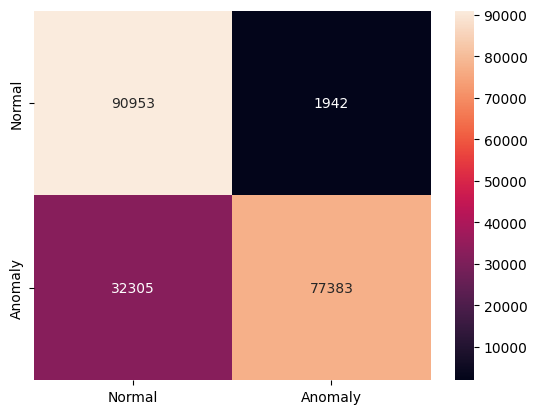

0.830948302671004

In [47]:
# evaluate model on validation data
predictions = best_model.predict(x_val_sequence)
cm = confusion_matrix(y_val_binary, predictions)
df_cm = pd.DataFrame(cm, index=["Normal", "Anomaly"], columns=["Normal", "Anomaly"])
sns.heatmap(df_cm, annot=True, fmt=".0f")
plt.show()

accuracy = accuracy_score(y_val_binary, predictions)
project_results["XGBoost binary"] = accuracy
accuracy

## XGBoost muti-label classification

We also have to make adjustments to the available data for the mutli-label classification. The model expects continuous integer labels. Since we removed labels 3, 9 and 15 at the beginning, we have to realign the labels. To do this, we use a mapping dictionary (`label_mapping`) that maps the initial labels to new labels and the function `realign_labels` that applies the mapping to the data.

In [48]:
# dictionary to map old labels to new
label_mapping = {k: i for i, k in enumerate(set(y_train))}
# reverse mapping for evaluation later
reverse_label_mapping = {i: k for i, k in enumerate(set(y_train))}

# functions to apply mappings to data
realign_labels = np.vectorize(lambda x: label_mapping[x])
reverse_map_labels = np.vectorize(lambda x: reverse_label_mapping[x])

In [49]:
# transform data
y_train_multilabel = realign_labels(y_train)
y_val_multilabel = realign_labels(y_val)

In [50]:
# define model type
xgb_model = XGBClassifier(device='cuda', objective="multi:softprob")
# define possible hyperparameters
optimization_dict = {'max_depth': [2,4,6], 'n_estimators': [50,100,200], "eta": [0.3, 0.03, 0.003]}

# search for the best model based on the possible hyperparamters
model = GridSearchCV(xgb_model, optimization_dict, scoring='accuracy', verbose=1)
model.fit(x_train_sequence, y_train_multilabel)

# print parameters and score of the best model
print(model.best_score_)
print(model.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
0.4764651934970061
{'eta': 0.3, 'max_depth': 6, 'n_estimators': 200}


In [51]:
# save the best model to disk
best_model = model.best_estimator_
best_model.save_model("./model/xgboost/XGBClassifier_multilabel.json")

In [52]:
# loading trained model
best_model = XGBClassifier(device='cuda', objective="multi:softprob")
best_model.load_model("./model/xgboost/XGBClassifier_multilabel.json")

The multi-label classification model perfoms worse than the binary classification model. This outcome could be assumed as multi-label classfication is harder because of the different classes. In binary classficiation the task is only to detect whether an datapoint in an anomaly or in normal state.

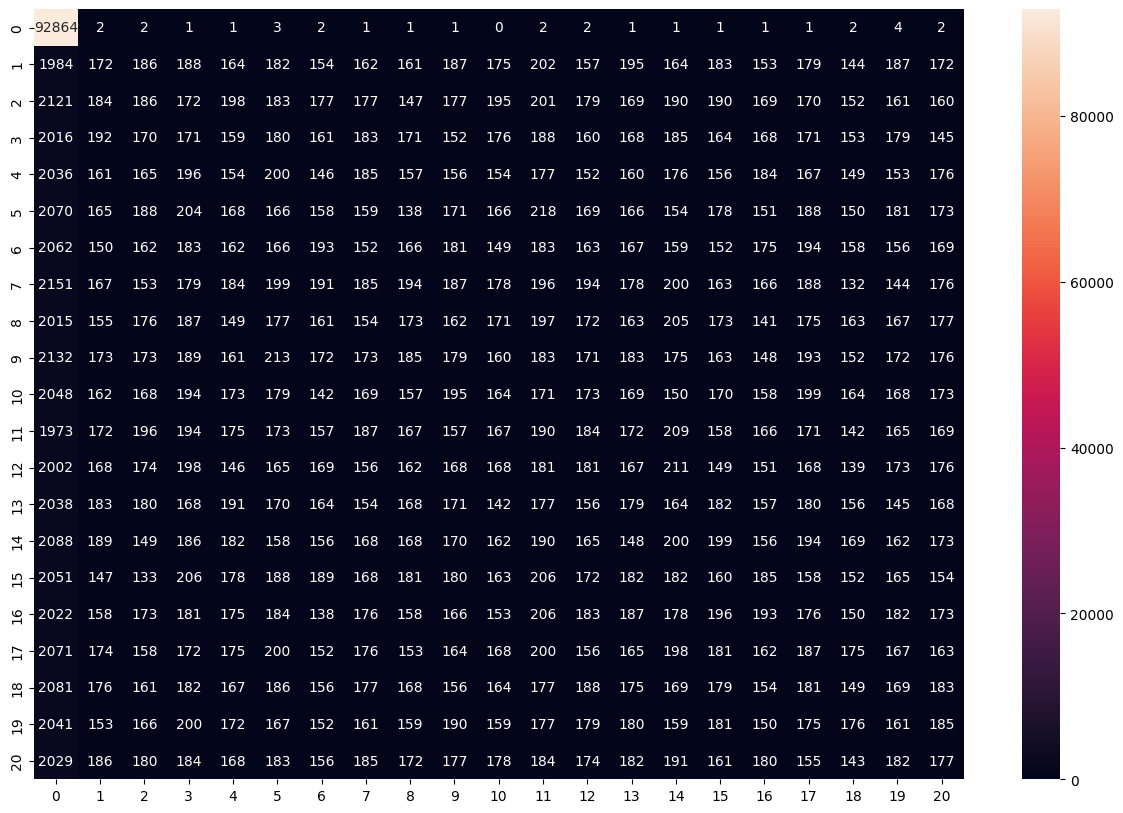

<Figure size 1500x1500 with 0 Axes>

0.4757753612099732

In [53]:
predictions = best_model.predict(x_val_sequence)
cm = confusion_matrix(y_val_multilabel, predictions)
cols = list(set(reverse_map_labels(y_val_multilabel)))
df_cm = pd.DataFrame(cm, index=cols, columns=cols)
plt.figure(figsize=(15, 10))
sns.heatmap(df_cm, annot=True, fmt=".0f")
plt.figure(figsize=(15,15))
plt.show()

accuracy = accuracy_score(y_val_multilabel, predictions)
project_results["XGBoost multi-label"] = accuracy
accuracy

## LSTM binary classification
Now we will train a *LSTM* for binary classification. To ensure that the output of the *LSTM* is between 0 and 1, we use the sigmoid activation function for the last layer. The sigmoid function maps our data to an output between 0 and 1. However, since our labels are either 0 or 1 and not in between, the output of the network is rounded so that we get the values 0 or 1.

In [54]:
class BinaryLSTM(nn.Module):
    """LSTM for binary time series classification."""
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.0):
        """Initialize LSTM.

        Args:
            input_size: Number of features
            hidden_size: Dimension of the hidden size of the LSTM
            num_layer: Number of LSTM layers
            dropout: Specifies the percentage of neurons on which dropout should 
                be applied during training to prevent overfitting.
        """
        super(BinaryLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True,
            bidirectional=False
        )
        self.linear1 = nn.Linear(hidden_size, 1)

    def forward(self, X):
        """Predicts if the input data is in a normal state or an anomaly.

        Args:
            X: Time series input data

        Returns:
            Prediction of data is in normal state (0) or is anomaly (1).
        """
        output, (hidden_state, cell_state) = self.lstm(X)
        output = self.linear1(output[:, -1, :])
        output = torch.sigmoid(output)
        return output

In [55]:
# defining a trainloader to process training in batches and shuffle the data
train_data = TEP(X_train, y_train_binary)
trainloader = DataLoader(train_data, batch_size=256, shuffle=True)

We need to convert the test labels to binary labels because we have not done it before. The XGBoost algorithm did not use the test data and only was evaluated on the validation data.

In [56]:
# convert y_test to binary
y_test_binary = to_binary(y_test)

# defining a testloader for evaluate model on test data during training
test_data = TEP(X_test, y_test_binary)
testloader = DataLoader(test_data, batch_size=256)

We will use the `EarlyStopping` class to end the training when the model perfomance doesn't get better on test accuracy so that we end up with the model with the best training accuracy.

In [57]:
class EarlyStopping:
    """Class to stop training when perfomance does not increase."""
    def __init__(self, tolerance=3, min_delta=0):
        """Initialize EarlyStopping.

        Args:
            tolerance: Number of tolerance that a model can't in increase it's perfomance
            min_delta: Value by which the perfomance should increase at least
        """
        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False
        self.best_accuracy = None

    def __call__(self, test_accuracy):
        """Magic method for calling the EarlyStopping

        Args:
            test_accuracy: The actual test accuracy of the current training state.
        """
        if self.best_accuracy is None:
            self.best_accuracy = test_accuracy
        else:
            if (test_accuracy - self.min_delta) > self.best_accuracy:
                self.best_accuracy = test_accuracy
            else:
                self.counter += 1
                if self.counter > self.tolerance:
                    self.early_stop = True
                    print("Early stopping!")

In [58]:
# number of training epochs
num_epochs = 20

# learning rate
learning_rate = 0.0002

# model
model = BinaryLSTM(input_size=52, hidden_size=109, num_layers=2, dropout=0.2).to(device)

# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

# criterion
loss_fn = nn.BCELoss()

# early stopping instance
early_stopper = EarlyStopping(min_delta=0.01)

# metric that will be stored during training
best_acc = 0
train_losses = []
test_losses = []
train_accs = []
test_accs = []

# start training loop
for i in range(num_epochs):
    # epoch metrics stored during training
    train_epoch_losses = []
    test_epoch_losses = []
    with tqdm(total=len(trainloader)) as pbar:
        # set model into training state
        model.train()
        correct_predictions = 0
        total_samples = 0
        for x, y in trainloader:
            # get data to model device
            x = x.to(device)
            # reshape label to batch_size, 1
            y = y[:, None]
            y = y.to(device).to(torch.float32)
            # predict on input data
            pred = model(x)
            # calculate loss
            loss = loss_fn(pred, y)
            # reset gradients to 0
            optimizer.zero_grad()
            # calculate new gradients
            loss.backward()
            # take a optimization step gradient direction
            optimizer.step()

            # store the loss
            loss = loss.detach().item()
            train_epoch_losses.append(loss)

            correct_predictions += (torch.round(pred) == y).sum().cpu().item()
            total_samples += len(y)
            pbar.update(1)
        train_acc = correct_predictions / total_samples

        # evaluate model on test data
        model.eval()
        correct_predictions = 0
        total_samples = 0
        for x, y in testloader:
            x = x.to(device)
            y = y[:, None]
            y = y.to(device).to(torch.float32)
            with torch.no_grad():
                pred = model(x)
            loss = loss_fn(pred, y)
            loss = loss.detach().item()
            test_epoch_losses.append(loss)
            correct_predictions += (torch.round(pred) == y).sum().cpu().item()
            total_samples += len(y)
        test_acc = correct_predictions / total_samples

        # evaluations
        e_train = np.mean(train_epoch_losses)
        e_test = np.mean(test_epoch_losses)
        train_losses.append(e_train)
        test_losses.append(e_test)
        train_accs.append(train_acc)
        test_accs.append(test_acc)
                
        print(f"Epoch {i+1} - train loss: {e_train} train acc: {train_acc} \
            \t test loss: {e_test} test acc: {test_acc}")

        # save model with best test accuracy
        if test_acc > best_acc:
            torch.save(model.state_dict(), "./model/binary_lstm/model.pt")

        # check if early stopping should be called
        early_stopper(test_acc)
        if early_stopper.early_stop:
            break

100%|█████████████████████████████████████████████████████████████████████████████| 3693/3693 [00:10<00:00, 342.58it/s]


Epoch 1 - train loss: 0.6799733465743717 train acc: 0.5441073338220221             	 test loss: 0.6618910960175775 test acc: 0.5517859258381709


100%|█████████████████████████████████████████████████████████████████████████████| 3693/3693 [00:10<00:00, 352.45it/s]


Epoch 2 - train loss: 0.6174736563958613 train acc: 0.6835941260034251             	 test loss: 0.540229635934035 test acc: 0.8440350669351973


100%|█████████████████████████████████████████████████████████████████████████████| 3693/3693 [00:10<00:00, 360.40it/s]


Epoch 3 - train loss: 0.39693569020546454 train acc: 0.9006523254497893             	 test loss: 0.2570435731210793 test acc: 0.9332671879319197


100%|█████████████████████████████████████████████████████████████████████████████| 3693/3693 [00:10<00:00, 361.06it/s]


Epoch 4 - train loss: 0.18886015583974639 train acc: 0.9483692921523144             	 test loss: 0.1415707634178677 test acc: 0.9602535244639261


100%|█████████████████████████████████████████████████████████████████████████████| 3693/3693 [00:09<00:00, 377.46it/s]


Epoch 5 - train loss: 0.12088745744279042 train acc: 0.9656965877466054             	 test loss: 0.10192202944120374 test acc: 0.9709700667377483


100%|█████████████████████████████████████████████████████████████████████████████| 3693/3693 [00:09<00:00, 375.52it/s]


Epoch 6 - train loss: 0.09179408963585074 train acc: 0.9740032388852395             	 test loss: 0.07981772645084996 test acc: 0.9774315839355526


100%|█████████████████████████████████████████████████████████████████████████████| 3693/3693 [00:10<00:00, 367.88it/s]


Epoch 7 - train loss: 0.07356952325229864 train acc: 0.9791429329999249             	 test loss: 0.06443969288257638 test acc: 0.9814496702602378


100%|█████████████████████████████████████████████████████████████████████████████| 3693/3693 [00:10<00:00, 354.35it/s]


Epoch 8 - train loss: 0.06025324110118251 train acc: 0.9828398317302861             	 test loss: 0.05289279443277704 test acc: 0.9844114046518975


100%|█████████████████████████████████████████████████████████████████████████████| 3693/3693 [00:10<00:00, 357.13it/s]


Epoch 9 - train loss: 0.05011713220275113 train acc: 0.985675707408712             	 test loss: 0.04392573278811243 test acc: 0.9870720293804052


100%|█████████████████████████████████████████████████████████████████████████████| 3693/3693 [00:10<00:00, 353.13it/s]

Epoch 10 - train loss: 0.04232372912496829 train acc: 0.9880239520958084             	 test loss: 0.037064462147577845 test acc: 0.9890662638707894
Early stopping!


In [59]:
# validate model on validation data
val_data = TEP(X_val, y_val_binary)
validation_loader = DataLoader(val_data, batch_size=256)

# storing predictions and ground truth
preds = []
y_true = []

model.eval()
with tqdm(total=len(validation_loader)) as pbar:
    correct_predictions = 0
    total_samples = 0
    for x, y in validation_loader:
        x = x.to(device)
        y = y.to(device).to(torch.float32)
        with torch.no_grad():
            pred = model(x)
        predicted = torch.round(pred)
        y_true.extend(y.cpu().numpy())
        preds.extend(torch.round(pred).cpu().numpy())
        pbar.update(1)

accuracy = accuracy_score(y_true, preds)
project_results["LSTM binary"] = accuracy
accuracy

100%|███████████████████████████████████████████████████████████████████████████████| 792/792 [00:01<00:00, 711.44it/s]


0.9894561735190021

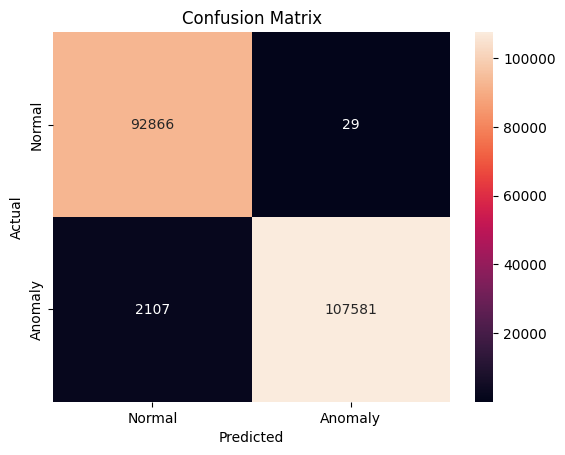

In [60]:
cm = confusion_matrix(y_true, preds)

cols = ["Normal", "Anomaly"]
df_cm = pd.DataFrame(cm, index=cols, columns=cols)

sns.heatmap(df_cm, annot=True, fmt=".0f")

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()

## LSTM multi-label classification
At last, we train a *LSTM* model for multi-label classification. By now we have alle the data prepared in the steps before an can definte the multi-label classification *LSTM* and start with the training.

Initially, we sampled the data in such a way that we have the same amount of data for anomalies as for data in the normal state. This sampling leads to problems with multi-label classifications, as the anomaly data is split into its different classes and is heavily underrepresented compared to the data in the normal state, as we can see below.

In [61]:
label_distribution = np.unique(y_train_multilabel, return_counts=True)
pd.DataFrame({"Label": label_distribution[0], "Samples": label_distribution[1]})

,Label,Samples
0,0,434623
1,1,25590
2,2,25667
3,3,25726
4,4,25581
5,5,25538
6,6,25314
7,7,25438
8,8,25464
9,9,25684


To ensure that the data is equally distributed again, we sample as much data from each label as is available from the most underrepresented class.

In [62]:
# convert labels to pandas series
data = pd.Series(y_train_multilabel)
# get count of least labels
n = data.value_counts().min()
# initialize new sampled labels
sampled_labels = pd.Series(index=[])

# Loop over every label for sampling
for value in data.unique():
    # sample n random labels with index
    samples = data[data == value].sample(n=n, replace=False)
    # append labels to sampled labels
    sampled_labels = sampled_labels._append(samples)

C:\Users\ckeibel\AppData\Local\Temp\ipykernel_17144\1699009723.py:13: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  sampled_labels = sampled_labels._append(samples)


In [63]:
sampled_label_distribution = np.unique(sampled_labels, return_counts=True)
pd.DataFrame({"Label": sampled_label_distribution[0], "Samples": sampled_label_distribution[1]})

,Label,Samples
0,0,25314
1,1,25314
2,2,25314
3,3,25314
4,4,25314
5,5,25314
6,6,25314
7,7,25314
8,8,25314
9,9,25314


In [64]:
train_data = TEP(X_train[sampled_labels.index], y_train_multilabel[sampled_labels.index])
trainloader = DataLoader(train_data, batch_size=256, shuffle=True)

In [65]:
y_test_multilabel = realign_labels(y_test)

# convert labels to pandas series
data = pd.Series(y_test_multilabel)
# get count of least labels
n = data.value_counts().min()
# initialize new sampled labels
sampled_labels = pd.Series(index=[])

# Loop over every label for sampling
for value in data.unique():
    # sample n random labels with index
    samples = data[data == value].sample(n=n, replace=False)
    # append labels to sampled labels
    sampled_labels = sampled_labels._append(samples)

C:\Users\ckeibel\AppData\Local\Temp\ipykernel_17144\3424130488.py:15: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  sampled_labels = sampled_labels._append(samples)


In [66]:
class ClassificationLSTM(nn.Module):
    """Multi-label classification LSTM for time series"""
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.0):
        super(ClassificationLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True,
            bidirectional=False
        )
        self.intermediate_size = hidden_size//2
        self.linear1 = nn.Linear(hidden_size, 300)
        self.linear2 = nn.Linear(300, 150)
        self.linear3 = nn.Linear(150, output_size)

    def forward(self, X):
        output, (hidden_state, cell_state) = self.lstm(X)
        output = self.linear1(output[:, -1, :])
        output = self.linear2(output)
        output = self.linear3(output)
        return output

In [67]:
test_data = TEP(X_test[sampled_labels.index], y_test_multilabel[sampled_labels.index])
testloader = DataLoader(test_data, batch_size=256)

In [68]:
num_epochs = 20

# model
learning_rate = 0.002
model = ClassificationLSTM(input_size=52, hidden_size=1024, num_layers=12, output_size=len(set(y_train_multilabel)), dropout=0.2).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()

early_stopper = EarlyStopping()

for i in range(num_epochs):
    train_epoch_losses = []
    test_epoch_losses = []
    train_correct = 0
    train_samples = 0
    test_correct = 0
    test_samples = 0
    with tqdm(total=len(trainloader)) as pbar:
        model.train()
        correct_predictions = 0
        total_samples = 0
        for x, y in trainloader:
            x = x.to(torch.float32).to(device)
            y = y.to(torch.long).to(device)
            pred = model(x)
            loss = loss_fn(pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss = loss.detach().item()
            train_epoch_losses.append(loss)
            
            pbar.update(1)
            _, pred = torch.max(pred.data, 1)
            correct_predictions += (pred == y).sum().item()
            total_samples += y.size(0)
        train_acc = correct_predictions / total_samples
        
        model.eval()
        correct_predictions = 0
        total_samples = 0
        for x, y in testloader:
            x = x.to(torch.float32).to(device)
            y = y.to(torch.long).to(device)
            with torch.no_grad():
                pred = model(x)
            loss = loss_fn(pred, y)
            loss = loss.detach().item()
            test_epoch_losses.append(loss)
            _, pred = torch.max(pred.data, 1)
            correct_predictions += (pred == y).sum().item()
            total_samples += y.size(0)
        test_acc = correct_predictions / total_samples
        
        # evaluations
        e_train = np.mean(train_epoch_losses)
        e_test = np.mean(test_epoch_losses)
                
        print(f"Epoch {i+1} - train loss: {e_train} train acc: {train_acc} \
            \t test loss: {e_test} test acc: {test_acc}")

        if test_acc > best_acc:
            torch.save(model.state_dict(), "./model/classification_lstm/model.pt")

        early_stopper(test_acc)
        if early_stopper.early_stop:
            break

100%|█████████████████████████████████████████████████████████████████████████████▉| 2076/2077 [03:40<00:00,  9.58it/s]

Epoch 1 - train loss: 3.044785876887087 train acc: 0.04749113044917738             	 test loss: 3.044531329185175 test acc: 0.047619047619047616


100%|█████████████████████████████████████████████████████████████████████████████▉| 2076/2077 [03:39<00:00,  9.45it/s]

Epoch 2 - train loss: 3.0445645617704065 train acc: 0.0474064793808809             	 test loss: 3.0445458354993105 test acc: 0.047619047619047616


100%|█████████████████████████████████████████████████████████████████████████████▉| 2076/2077 [03:39<00:00,  9.47it/s]

Epoch 3 - train loss: 3.044569327157452 train acc: 0.04759459286598419             	 test loss: 3.044538201250102 test acc: 0.047619047619047616


100%|█████████████████████████████████████████████████████████████████████████████▉| 2076/2077 [03:39<00:00,  9.49it/s]

Epoch 4 - train loss: 3.0445591474761744 train acc: 0.04764350237211105             	 test loss: 3.044549609201526 test acc: 0.047619047619047616


100%|█████████████████████████████████████████████████████████████████████████████▉| 2076/2077 [03:39<00:00,  9.28it/s]

Epoch 5 - train loss: 3.0445711738970282 train acc: 0.04699827311820675             	 test loss: 3.0445347107373752 test acc: 0.047619047619047616


100%|██████████████████████████████████████████████████████████████████████████████| 2077/2077 [03:53<00:00,  8.90it/s]

Early stopping!


In [69]:
# validate model on validation data
val_data = TEP(X_val, y_val_multilabel)
validation_loader = DataLoader(val_data, batch_size=256)

preds = []
y_true = []

model.eval()
with tqdm(total=len(trainloader)) as pbar:
    correct_predictions = 0
    total_samples = 0
    for x, y in trainloader:
        x = x.to(device)
        y = y.to(device).to(torch.float32)
        with torch.no_grad():
            pred = model(x)
        _, predicted_labels = torch.max(pred, dim=1)
        y_true.extend(y.cpu().numpy())
        preds.extend(pred.argmax(dim=1).cpu().numpy())
        pbar.update(1)

accuracy = accuracy_score(y_true, preds)
project_results["LSTM multi-label"] = accuracy
accuracy

100%|██████████████████████████████████████████████████████████████████████████████| 2077/2077 [01:00<00:00, 34.10it/s]


0.047619047619047616

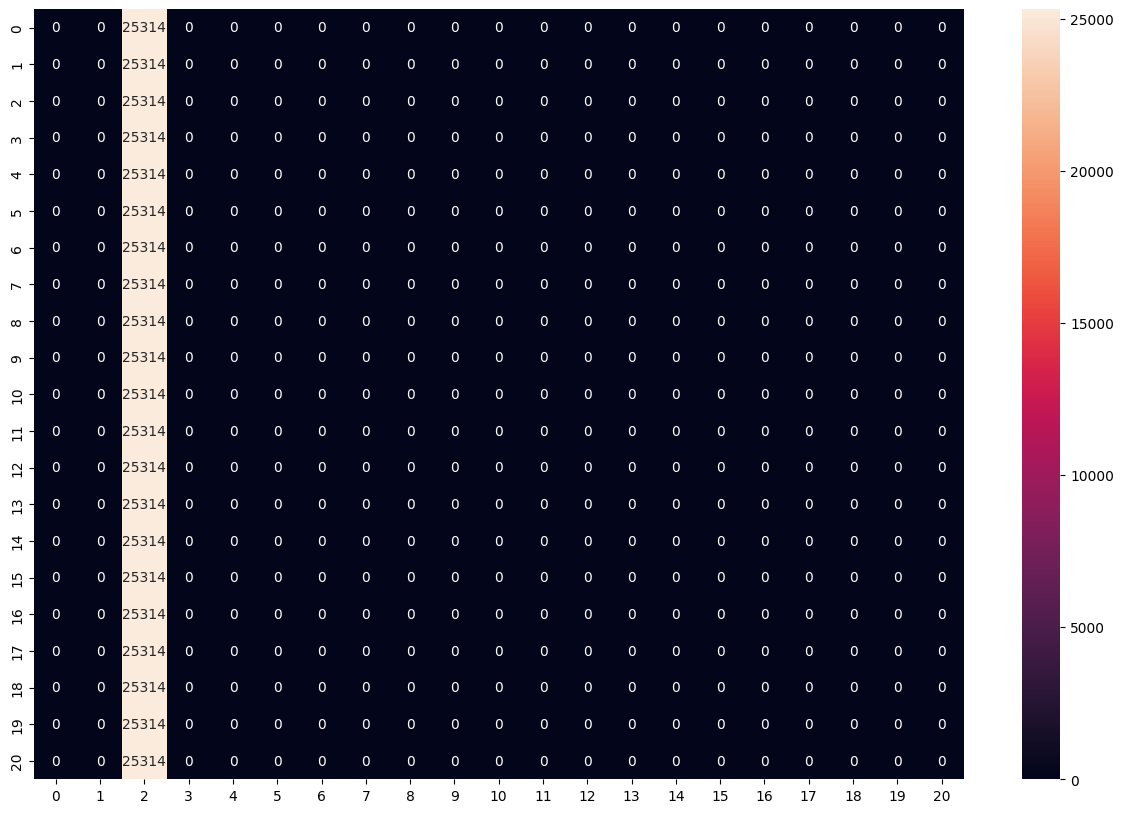

In [70]:
cm = confusion_matrix(y_true, preds)
cols = list(set(reverse_map_labels(y_val_multilabel)))
df_cm = pd.DataFrame(cm, index=cols, columns=cols)
plt.figure(figsize=(15, 10))
sns.heatmap(df_cm, annot=True, fmt=".0f")
plt.show()

# Results
It can be said that the neural approaches achieve better results than the classical machine learning algorithms. This may be mainly due to the fact that the special architecture of a recurrent neural network is well suited to modeling time series. In addition, neural networks learn representations during training, so that almost no feature engineering is necessary.
These aspects do not apply to classical machine learning algorithms. Complex feature engineering is required to train these algorithms, and they are also not good at modeling time dependencies.

**Note:**
Unfortunately, I have not been able to get the multi-label classification LSTM to learn in several approaches. Various hyperparameters such as model capacity, learning rate, learning rate scheduler and various optimizers were tried.

In [85]:
project_results_df = pd.DataFrame(project_results, index=[i for i in range(len(project_results))])[:1].T
project_results_df.columns = ["Accuracy"]
project_results_df.to_csv("results.csv")
project_results_df

,Accuracy
statistical analysis,0.755580
VAE,0.849188
XGBoost binary,0.830948
XGBoost multi-label,0.475775
LSTM binary,0.989456
LSTM multi-label,0.047619
